In [1]:
# Parameters
symbol = 'SPY'
start_date = None # "1970"

In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf

import numba
from scipy.optimize import minimize

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

import seaborn as sns

from IPython.display import set_matplotlib_formats

# set_matplotlib_formats('svg')
mpl.rcParams['figure.figsize'] = [16, 12]

In [4]:
ty_rates = pd.read_csv("DGS10_clean.csv")
ty_rates.rename(columns={"DGS10": "rate", "DATE": "date"}, inplace=True)
ty_rates.rate /= 100.

ty_rates["date"] = pd.to_datetime(ty_rates["date"])

def ty_ret(rate, date):
    yr_date = date.dt.year.add(
        date.dt.dayofyear.sub(1)
        .div(date.dt.year + date.dt.is_leap_year)
    )    
    dt = yr_date.diff()
    resid = rate.add(1).pow(-10)
    ret = rate.shift().mul(1 - resid).div(rate).add(resid).sub(1)
    ret += rate.shift().mul(dt).div(1 + rate / np.e)  # no idea why
    return ret

ty_rates["ret"] = ty_ret(ty_rates.rate, ty_rates.date)
ty_rates = ty_rates.set_index("date")

In [5]:
data = yf.Ticker(symbol).history(period='max', auto_adjust=True)[start_date:]

In [6]:
# Note that when using ^GSPC, there are no dividends, and it's also 
# not really directly tradeable - I'll do a continuous futures version 
# at some point

# Rest of analysis assumes non-stock allocation is in cash, 
# but in reality you would have some gains from being in bonds as well

# We add transaction costs further down this sheet

sp_rets = data['Close'].transform(lambda xs: xs / xs.shift() - 1).rename('rets')

In [7]:
def plot_dd(rets):
    c_pl = rets.add(1).cumprod()

    c_pl.plot(lw=1, color='black', logy=True)
    plt.fill_between(
        c_pl.index,
        c_pl,
        c_pl.cummax(),
        facecolor='red',
        alpha=0.5,
    )

In [8]:
windows = list(range(30, 211, 30))
print(windows)
feats = pd.concat([
    sp_rets.shift().cumsum()
    .transform(lambda xs: xs.rolling(i).mean().gt(xs.rolling(j).mean()).rename(f"{i}/{j}"))
    for i in windows
    for j in [250]
    if i * 2 < j
], axis=1)
print(feats.columns)

[30, 60, 90, 120, 150, 180, 210]
Index(['30/250', '60/250', '90/250', '120/250'], dtype='object')


In [9]:
# target = sp_rets.iloc[::-1].rolling(30).mean().iloc[::-1]
target = sp_rets

In [10]:
mask = feats.notnull().all(axis=1) & target.notnull()

In [11]:
feats = feats[mask]
target = target[mask]

In [12]:
col = feats.columns[0]

In [28]:
def fit_wt(train_ix):
    wts = []
    for col in feats:
        wts.append(
            feats[train_ix].reset_index().merge(
                target[train_ix].groupby(feats[train_ix][col])
                .agg([("x", "mean"), ("x2", lambda xs: xs.pow(2).mean())])
                .reset_index()
            )
        )
    wts = pd.concat(wts)
    wts = wts.groupby(list(feats.columns), as_index=False)[["x", "x2"]].mean()
    wts["var"] = wts["x2"] - wts["x"].pow(2)
    wts["mu_var"] = wts["x"] / wts["var"]
    return wts

In [14]:
%%time
wts = []
periods = np.arange(feats.shape[0]) // 100
for p in np.unique(periods)[11:]:
    train_ix = periods < p
#     train_ix &= (p - 10 <= periods)
    wts.append(fit_wt(train_ix).assign(period=p))
wts = pd.concat(wts)
wts

CPU times: user 974 ms, sys: 3.13 ms, total: 977 ms
Wall time: 978 ms


,30/250,60/250,90/250,120/250,x,x2,var,mu_var,period
0,False,False,False,False,0.000475,0.000032,0.000031,15.162026,11
1,False,False,False,True,0.000570,0.000038,0.000038,15.164386,11
2,False,False,True,True,0.000641,0.000045,0.000045,14.316488,11
3,False,True,True,True,0.000759,0.000052,0.000051,14.760875,11
4,True,False,False,False,0.000542,0.000039,0.000039,14.066979,11
...,...,...,...,...,...,...,...,...,...
7,True,False,True,True,0.000449,0.000144,0.000143,3.130399,78
8,True,True,False,False,0.000311,0.000174,0.000174,1.784142,78
9,True,True,False,True,0.000453,0.000139,0.000139,3.264427,78
10,True,True,True,False,0.000400,0.000139,0.000138,2.889540,78


In [15]:
(
    wts.set_index(list(feats.columns) + ["period"]).mu_var.unstack("period").iloc[:, -10:]
    .style.background_gradient(axis=None, cmap='YlOrRd')
)

In [29]:
sizing = feats.assign(period=periods).reset_index().merge(wts, how="left").set_index("Date").mu_var
sizing = sizing.clip(lower=0.)
# sizing = sizing.rolling(30).mean()
sizing *= 1. / sizing.iloc[-2500:].mean()
sizing = sizing.clip(upper=1.2)

<AxesSubplot:xlabel='Date'>

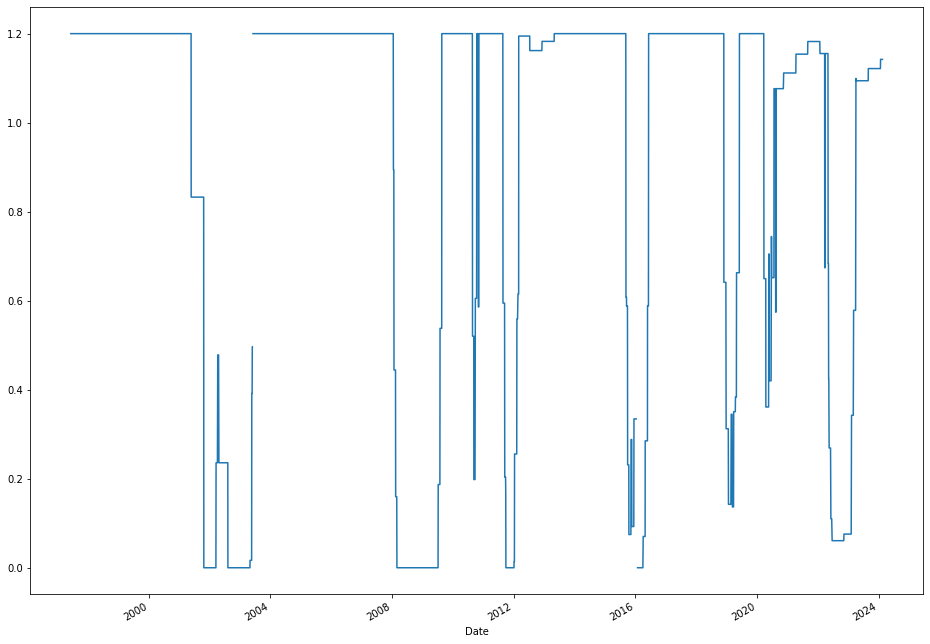

In [30]:
sizing.plot()

In [31]:
sp_rets.pipe(lambda xs: xs.mean() / xs.std() * 250**0.5)

0.6075409551278874

In [32]:
sp_rets.mul(sizing).pipe(lambda xs: xs.mean() / xs.std() * 250**0.5)

0.5726168586242981

In [33]:
strat = sp_rets.mul(sizing)

In [34]:
strat.add(1).groupby(pd.Grouper(freq="Y")).prod().sub(1).mean()

0.08272305329546632

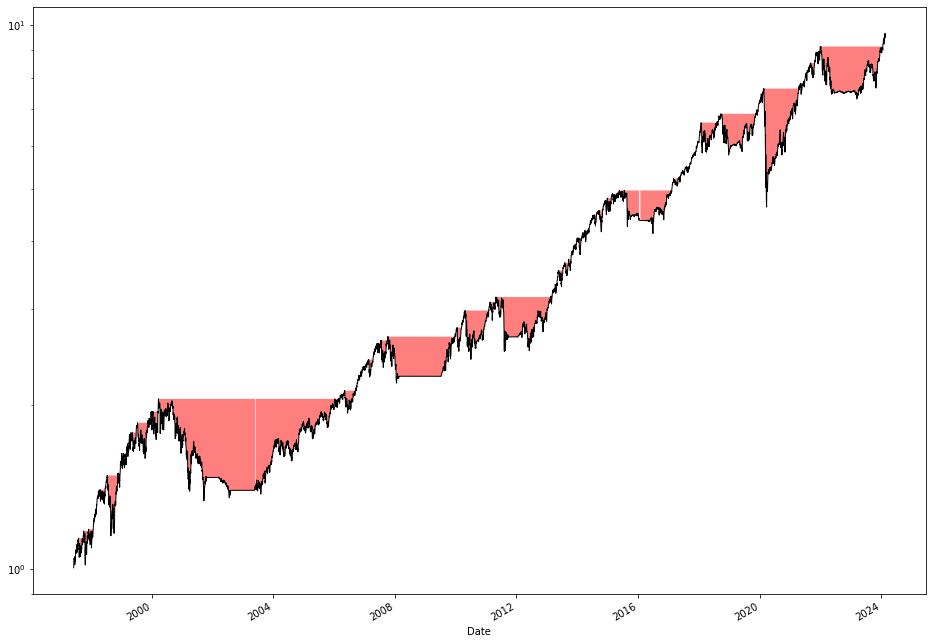

In [35]:
plot_dd(strat)
# sp_rets[strat.notnull()].add(1).cumprod().plot(logy=True)

In [36]:
(sp_rets.loc[strat.notnull()].pipe(lambda xs: xs.mean() / xs.std()),
 strat.pipe(lambda xs: xs.mean() / xs.std()))

(0.032710533596404356, 0.03621546999726826)

<AxesSubplot:xlabel='Date'>

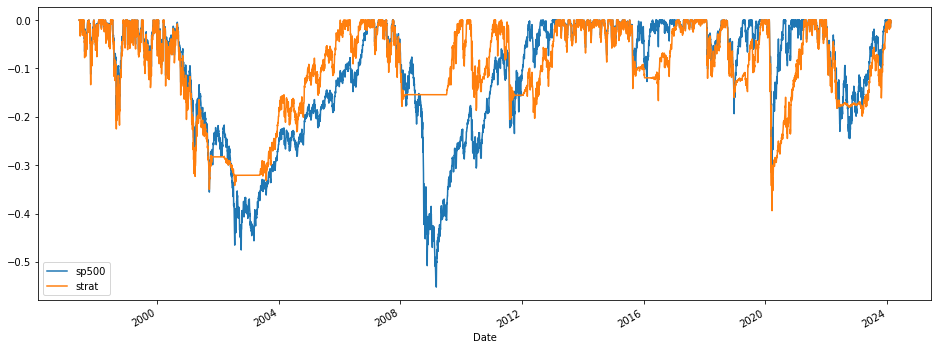

In [37]:
(
    pd.DataFrame({"sp500": sp_rets, "strat": strat})
    .dropna()
    .add(1).cumprod()
    .transform(lambda xs: xs / xs.cummax() - 1).plot(figsize=(16, 6))
)

<AxesSubplot:xlabel='Date'>

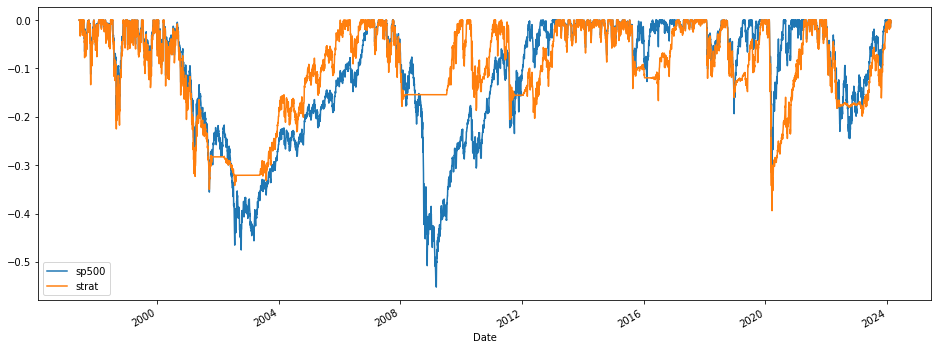

In [38]:
(
    pd.DataFrame({"sp500": sp_rets, "strat": strat})
    .dropna()["1980":]
    .add(1).cumprod()
    .transform(lambda xs: xs / xs.cummax() - 1).plot(figsize=(16, 6))
)